# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [17]:
target = TuringTarget(stat_model);

In [18]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [19]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 16.647539991198034
eps: 0.125 --> VarE: 42.34552440018154
eps: 0.0625 --> VarE: 5.852245887510531
eps: 0.03125 --> VarE: 1.9456354760022454


[ Info: Found eps ✅


Row,Ω,E,logp
,Any,Any,Any
1,"[0.288636, 0.673529]",0.0,9.78684
2,"[0.288636, 0.673529]",3.36032,13.1964
3,"[0.300247, 0.702542]",9.13803,15.6687
4,"[0.312733, 0.731189]",5.19397,16.5708
5,"[0.34041, 0.745699]",2.24568,17.6419
6,"[0.327734, 0.774262]",1.04023,16.5495
7,"[0.339045, 0.745131]",-2.55767,16.0829
8,"[0.369762, 0.739385]",0.122085,17.0759
9,"[0.363488, 0.769999]",0.994774,16.0797


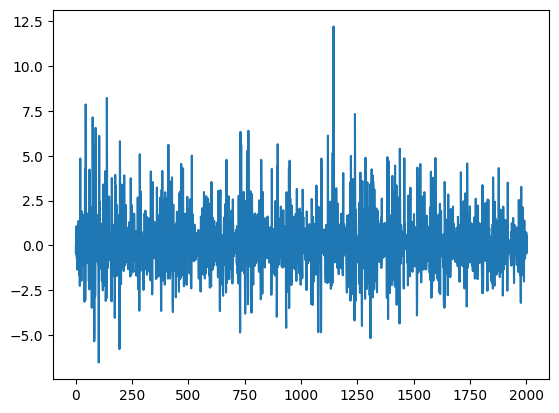

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda0568e7c0>

In [20]:
plt.plot(samples_mchmc.E[8000:end])

In [21]:
mean(samples_mchmc.E[8000:end])

0.05012845433540521

In [22]:
std(samples_mchmc.E[8000:end])^2/target.d

1.41758965966019

In [23]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

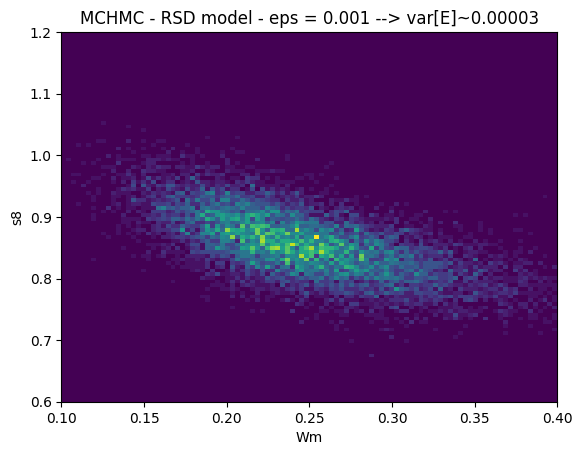

In [24]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [25]:
ctxt = stat_model

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

In [26]:
sample(stat_model, mchmc, 10000;
       monitor_energy=true, 
       dialog=true)

Using given hyperparameters


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


10000-element Vector{Tuple{Vector{Float64}, Float64, Float64}}:
 ([0.2079064447828568, 1.2768919807832897], 0.0, -35.44165769529895)
 ([0.2079064447828568, 1.2768919807832897], 10.675158453613086, -22.607076301724746)
 ([0.18379331055836384, 1.257014373837996], 31.266440859834276, -11.1021517779392)
 ([0.15876260023036626, 1.2383053909560786], 28.97227814344827, -1.2684160797891033)
 ([0.13252273452139787, 1.2213338869692392], 26.399695431009288, 6.104379209737994)
 ([0.10530434205604935, 1.20598065891771], 16.572537282886614, 9.10418135722772)
 ([0.07731188273869616, 1.192088764829202], 6.67063366555915, 10.307890151398857)
 ([0.08998302118218501, 1.1635229679639658], 3.6255589724351402, 11.551630490065646)
 ([0.09413616066781451, 1.1325501745411422], 7.153495447182104, 10.06670261756177)
 ([0.07502894962712854, 1.107822113835808], 4.527975113550346, 12.297590836790341)
 ([0.10585603998879918, 1.112945881964187], 4.665576082353478, 13.382911187334575)
 ([0.10405065339005659, 1.0817480

## NUTS

In [18]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.54 seconds
Compute duration  = 11.54 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm   -0.9946    0.0096     0.0001    0.0008   31.1564    1.1032      ⋯
          σ8    0.0014    0.0006     0.0000    0.0001   31.0577    1.1044      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

    

In [19]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

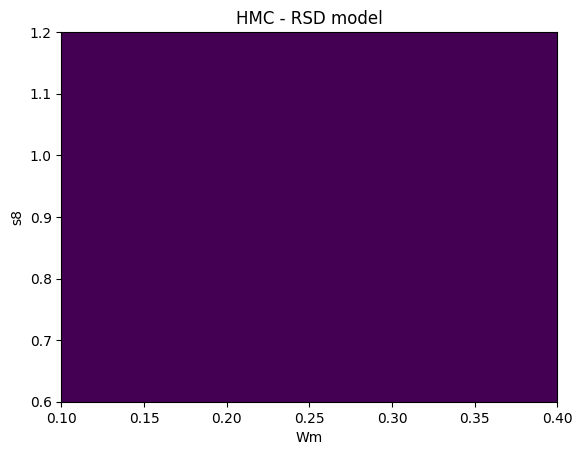

In [20]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");